# CDD project
investigating andronic receptor ligands.

In [1]:
#import all needed stuff
from rdkit.Chem import AllChem as Chem
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
from rdkit import RDLogger
lg = RDLogger.logger()
lg.setLevel(RDLogger.CRITICAL)
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import MolsMatrixToGridImage
from rdkit.Chem import Draw
import pandas as pd
from rdkit.Chem import MACCSkeys
from rdkit.Chem import AllChem
from rdkit.Chem.Pharm2D import Generate
from rdkit.Chem.Scaffolds import MurckoScaffold
from collections import Counter
from rdkit.Chem import rdMolDescriptors
from rdkit import DataStructs
from rdkit.SimDivFilters.rdSimDivPickers import MaxMinPicker
picker = MaxMinPicker()
import seaborn as sns
import itertools
from IPython.display import SVG
import csv
from rdkit.Chem.Pharm2D import Generate
from rdkit import DataStructs
from rdkit.Chem import Crippen
from matplotlib import pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef,roc_auc_score,roc_curve
import numpy as np

# Data loading
The source of our Androgenic receptor ligand data is DUD-E. This source provides chembl derived activity data for the actives as well as providing property matched decoys which are presumed inactive. Usually this data is used for docking benchmarks but we will use it for ligand based modelling

In [2]:
cdd2 = [mol for mol in Chem.SmilesMolSupplier("AR_actives.ism") if mol.GetProp("assay_type")=="IC50"]

In [3]:
print(f"we have {len(cdd2)} compounds with a measured IC50")

we have 526 compounds with a measured IC50


In [4]:
drugbank = [mol for mol in Chem.SDMolSupplier("../data/drugbank.sdf") if mol]

In [5]:
cdd2_mw = [rdescriptors.CalcExactMolWt(mol) for mol in cdd2]
cdd2_hb = [rdescriptors.CalcNumLipinskiHBA(mol) for mol in cdd2]
cdd2_hd = [rdescriptors.CalcNumLipinskiHBD(mol) for mol in cdd2]
cdd2_lp = [Descriptors.MolLogP(mol) for mol in cdd2]
cdd2_rotbond = [rdMolDescriptors.CalcNumRotatableBonds(mol) for mol in cdd2]
cdd2_tpsa = [rdescriptors.CalcTPSA(mol) for mol in cdd2]
cdd2_rings = [len(Chem.GetSSSR(mol)) for mol in cdd2]

In [6]:
db_mw = [rdescriptors.CalcExactMolWt(mol) for mol in drugbank]
db_hb = [rdescriptors.CalcNumLipinskiHBA(mol) for mol in drugbank]
db_hd = [rdescriptors.CalcNumLipinskiHBD(mol) for mol in drugbank]
db_lp = [Descriptors.MolLogP(mol) for mol in drugbank]
db_rotbond = [rdMolDescriptors.CalcNumRotatableBonds(mol) for mol in drugbank]
db_tpsa = [rdescriptors.CalcTPSA(mol) for mol in drugbank]
db_rings = [len(Chem.GetSSSR(mol)) for mol in drugbank]

In [7]:
sns.set(rc={'figure.figsize':(11.7, 11.7)})
ab = pd.DataFrame(data={'set':'cdd2', 'rings': cdd2_rings,
                        'rotbond': cdd2_rotbond, 
                        'hba': cdd2_hb, 'hbd': cdd2_hd, 'molwt': cdd2_mw,
                        'tpsa': cdd2_tpsa, 'logp': cdd2_lp, "rdmol": cdd2})
ab

,set,rings,rotbond,hba,hbd,molwt,tpsa,logp,rdmol
0,cdd2,4,0,2,1,290.224580,37.30,3.95910,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d22d50>
1,cdd2,4,0,3,2,336.210073,57.53,3.33220,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d22dc0>
2,cdd2,4,4,2,1,342.255880,37.30,5.35970,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d22e30>
3,cdd2,2,1,2,1,263.055799,44.02,3.94968,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d22f10>
4,cdd2,4,0,2,1,272.177630,37.30,3.55330,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d22ea0>
...,...,...,...,...,...,...,...,...,...
521,cdd2,4,12,3,1,596.332258,54.37,8.25230,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d79310>
522,cdd2,4,2,4,0,375.277344,46.61,4.27510,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d792a0>
523,cdd2,2,1,3,2,279.050713,64.25,3.65528,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d79380>
524,cdd2,4,4,4,0,374.293328,40.62,4.08680,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d793f0>


In [8]:
sns.set(rc={'figure.figsize':(11.7, 11.7)})
db = pd.DataFrame(data={'set':'drugbank', 'rings': db_rings,
                        'rotbond': db_rotbond, 
                        'hba': db_hb, 'hbd': db_hd, 'molwt': db_mw,
                        'tpsa': db_tpsa, 'logp': db_lp, "rdmol": drugbank})
db

,set,rings,rotbond,hba,hbd,molwt,tpsa,logp,rdmol
0,drugbank,6,66,57,31,2178.985813,901.57,-8.11643,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d79770>
1,drugbank,6,31,32,20,1268.641439,495.89,-3.10570,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d797e0>
2,drugbank,4,19,26,18,1068.426955,435.41,-4.13203,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d79850>
3,drugbank,6,38,31,20,1429.669818,495.67,-0.50613,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d22b20>
4,drugbank,1,15,23,5,1201.841368,278.80,3.26900,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7d798c0>
...,...,...,...,...,...,...,...,...,...
7115,drugbank,1,0,1,1,128.002892,20.23,2.04560,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7a99af0>
7116,drugbank,3,3,9,5,340.079432,149.82,-1.32270,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7a99b60>
7117,drugbank,6,14,27,13,1114.554641,403.10,1.54710,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7a99bd0>
7118,drugbank,0,13,5,0,330.147689,83.50,-0.00030,<rdkit.Chem.rdchem.Mol object at 0x7fb9c7a99c40>


In [9]:
import matplotlib.pyplot as plt

/tmp/ipykernel_504/1381268117.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt_hba.set(xticklabels=['cdd2_hb', 'db_hb', 'cdd2_hd', 'db_hd'], title='H-bond donors/acceptors')


[[Text(0, 0, 'cdd2_hb'),
  Text(1, 0, 'db_hb'),
  Text(2, 0, 'cdd2_hd'),
  Text(3, 0, 'db_hd')],
 Text(0.5, 1.0, 'H-bond donors/acceptors')]

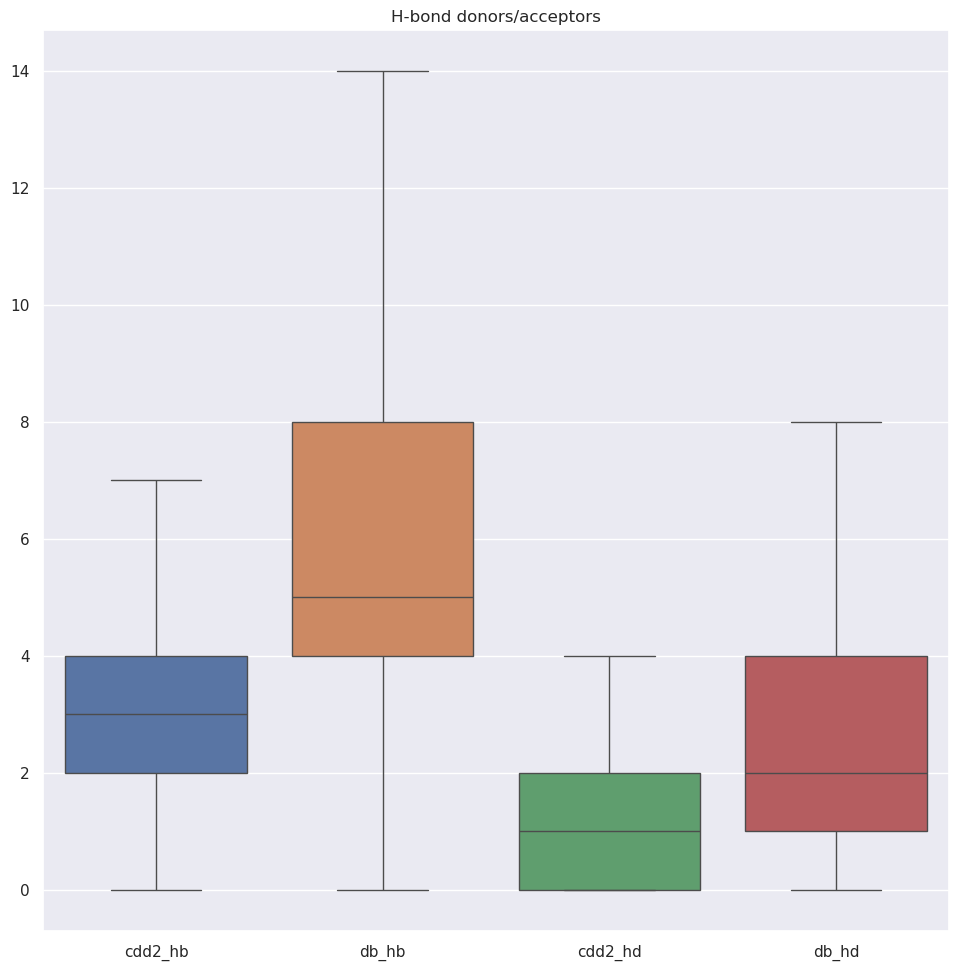

In [10]:
plt_hba = sns.boxplot([cdd2_hb, db_hb, cdd2_hd, db_hd], showfliers=False)
plt_hba.set(xticklabels=['cdd2_hb', 'db_hb', 'cdd2_hd', 'db_hd'], title='H-bond donors/acceptors')

/tmp/ipykernel_504/1612774178.py:2: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  plt_mw.set(xticklabels=['cdd2_mw', 'db_mw'], title='Molecular weight')


[[Text(0, 0, 'cdd2_mw'), Text(1, 0, 'db_mw')],
 Text(0.5, 1.0, 'Molecular weight')]

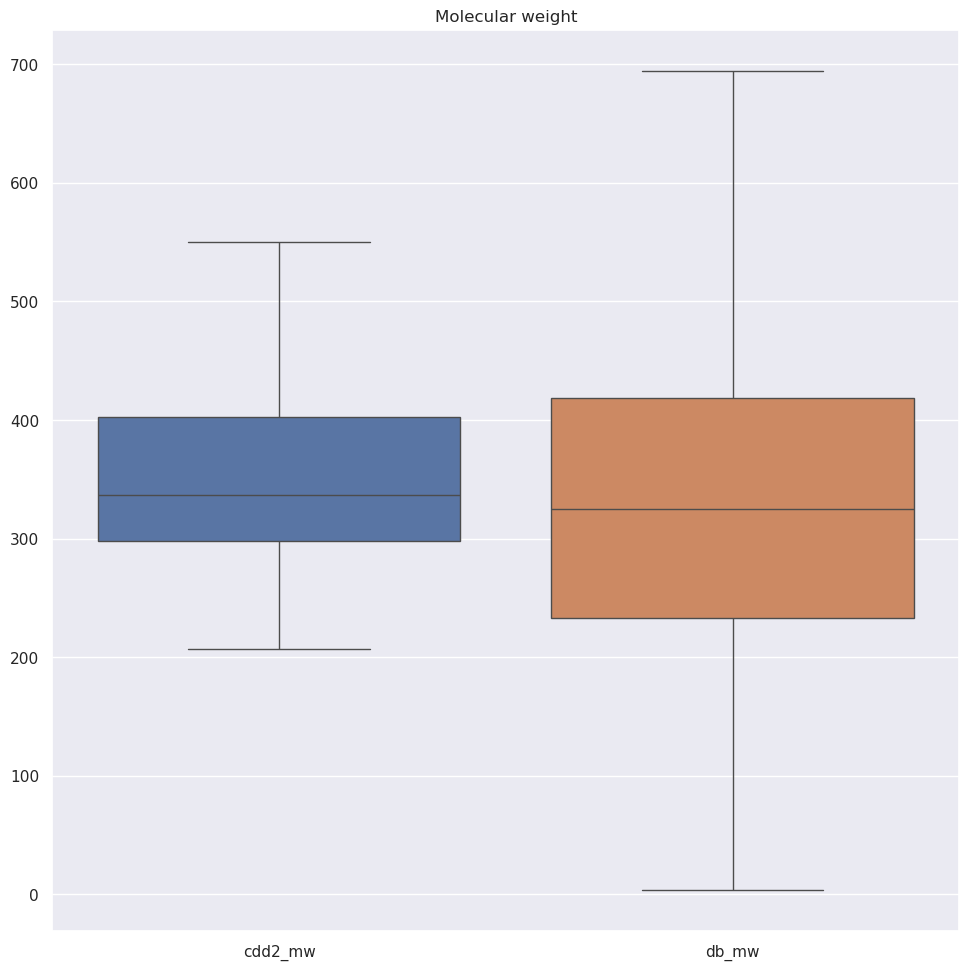

In [11]:
plt_mw = sns.boxplot([cdd2_mw, db_mw], showfliers=False)
plt_mw.set(xticklabels=['cdd2_mw', 'db_mw'], title='Molecular weight')

[Text(0.5, 0, 'Molecular Weight'),
 Text(0, 0.5, 'LogP'),
 Text(0.5, 1.0, 'Molecular Weight vs LogP')]

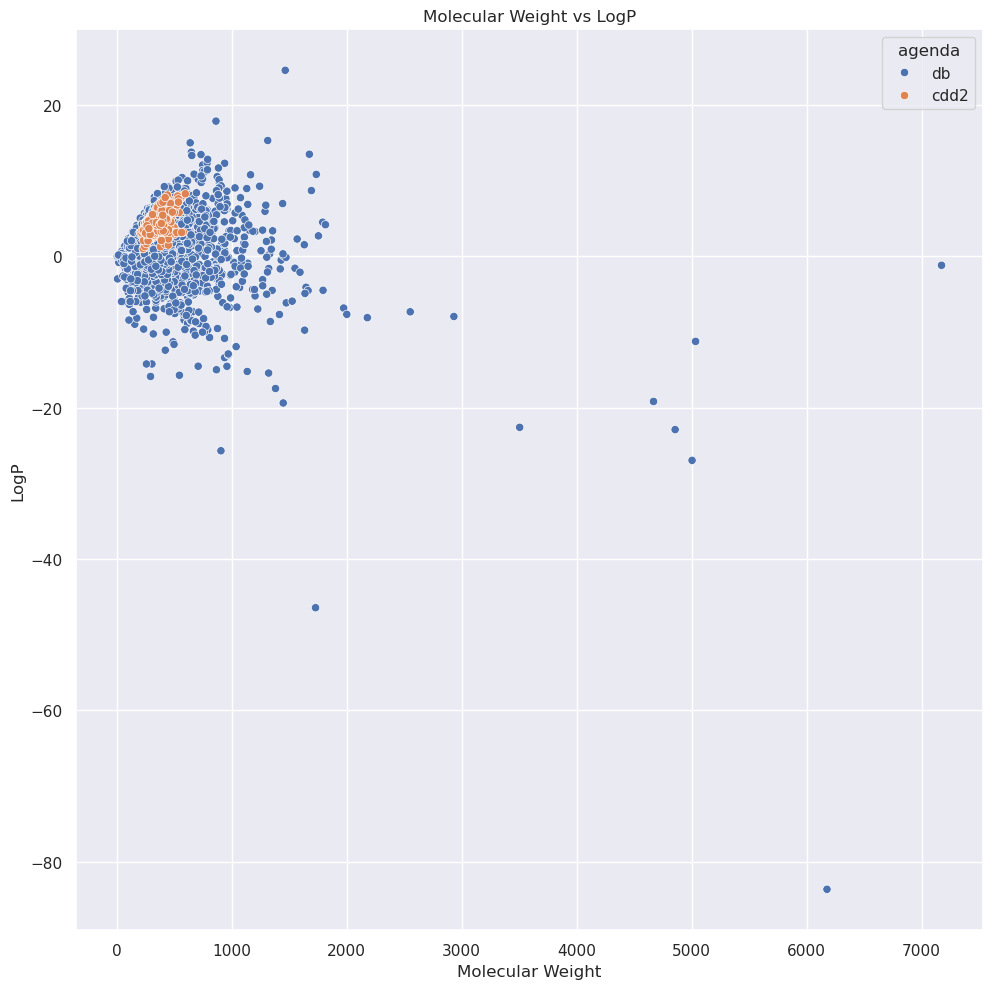

In [12]:
db_df = pd.DataFrame({'mw': db_mw, 'logp': db_lp, 'agenda': 'db'})
cdd2_df = pd.DataFrame({'mw': cdd2_mw, 'logp': cdd2_lp, 'agenda': 'cdd2'})
df = pd.concat([db_df, cdd2_df])

pltx = sns.scatterplot(data =df, x="mw", y='logp', hue='agenda')
pltx.set(xlabel='Molecular Weight', ylabel='LogP', title='Molecular Weight vs LogP')

[Text(0.5, 0, 'Molecular Weight'),
 Text(0, 0.5, 'TPSA'),
 Text(0.5, 1.0, 'Molecular Weight vs TPSA')]

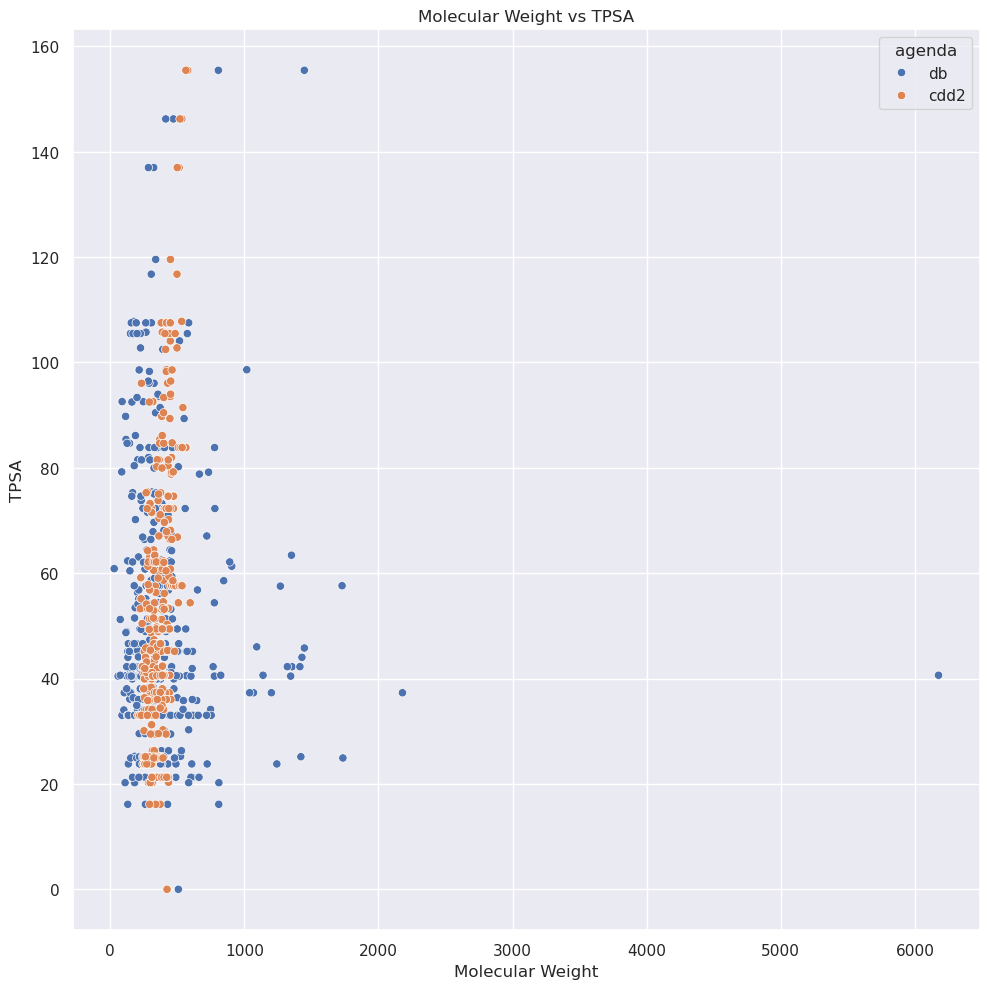

In [13]:
db_df = pd.DataFrame({'mw': db_mw, 'tspa': db_tpsa, 'agenda': 'db'})
cdd2_df = pd.DataFrame({'mw': cdd2_mw, 'tpsa': cdd2_tpsa, 'agenda': 'cdd2'})
df = pd.concat([db_df, cdd2_df])

pltx = sns.scatterplot(data =df, x="mw", y='tpsa', hue='agenda')
pltx.set(xlabel='Molecular Weight', ylabel='TPSA', title='Molecular Weight vs TPSA')

In [14]:
def get_lipinski(m):
    return [rdMolDescriptors.CalcNumLipinskiHBA(m),rdMolDescriptors.CalcNumLipinskiHBD(m),rdMolDescriptors.CalcExactMolWt(m),Crippen.MolLogP(m)]

def lipinski_violations(m):
    values = get_lipinski(m)
    violations = 0
    if values[0]>10:
        violations += 1
    if values[1]>5:
        violations += 1
    if values[2]>500:
        violations += 1
    if values[3]>5:
        violations += 1
    return violations

amount_lipinski_violations = sum([1 if lipinski_violations(mol)>0 else 0 for mol in cdd2])
print(f"percentage of lipinski violation for AR {amount_lipinski_violations/len(cdd2)*100}.")
amount_lipinski_violations = sum([1 if lipinski_violations(mol)>0 else 0 for mol in drugbank])
print(f"percentage of lipinski violation for drygbank {amount_lipinski_violations/len(drugbank)*100}.")

percentage of lipinski violation for AR 28.13688212927757.
percentage of lipinski violation for drygbank 25.68820224719101.


In [15]:
#calculate the fingerprints
fpcdd2 = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in cdd2]
fp_drug = [AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=1024) for mol in drugbank]
cdd2_maccs = [MACCSkeys.GenMACCSKeys(m) for m in cdd2]
drug_maccs = [MACCSkeys.GenMACCSKeys(m) for m in drugbank]

Scaffold: c1cnc2cc3c(cc2c1)CCCN3, Count: 35
Scaffold: c1ccc(Oc2ccccc2)cc1, Count: 28
Scaffold: O=C1CCC2C(CCC3C4CCCC4CCC23)N1, Count: 21
Scaffold: O=C(Nc1cccnc1)N1CCN(c2ccccc2)CC1, Count: 15
Scaffold: O=C1C=CC2C=CC=CC2N1, Count: 14
Scaffold: O=C1CCC2[C@@H](CC[C@H]3[C@@H]4CCCC4CC[C@H]23)C1, Count: 14
Scaffold: c1ccc(-c2ccccc2)cc1, Count: 13
Scaffold: O=C1CNC(=S)N1c1ccccc1, Count: 13
Scaffold: c1ccccc1, Count: 12
Scaffold: C1=C2CCCCC2C2CCC3CCCC3C2C1, Count: 12


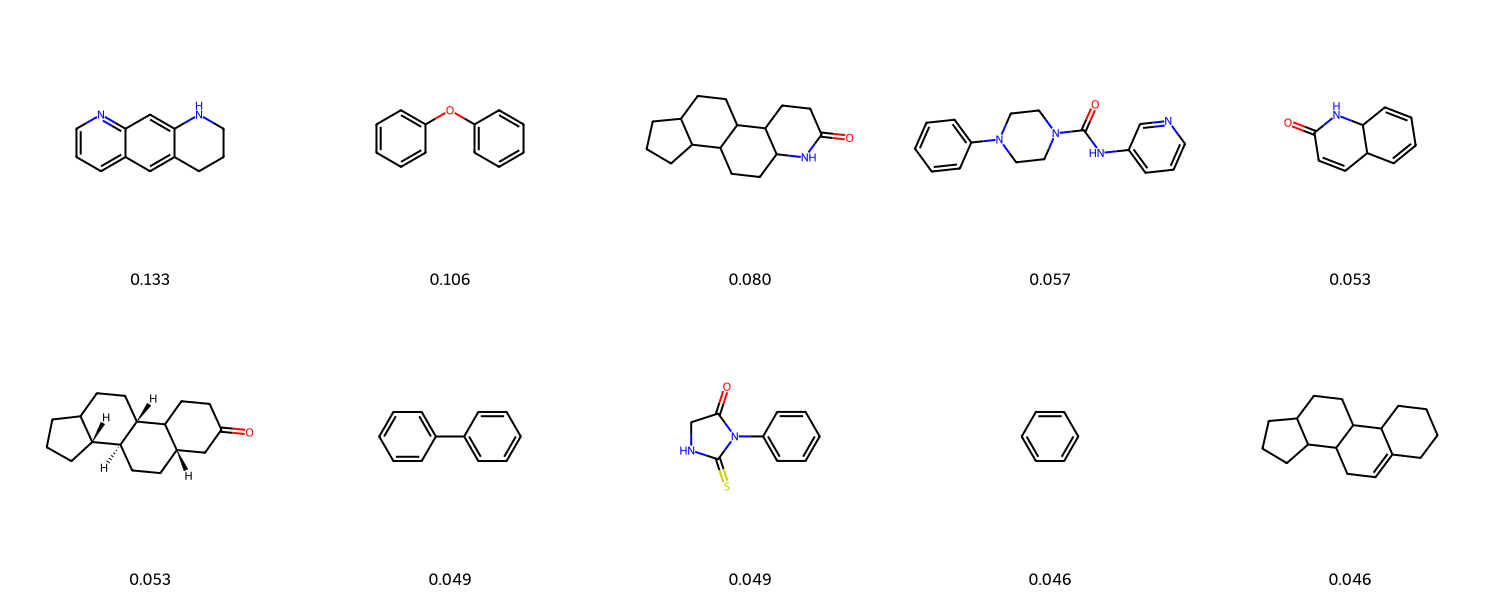

In [16]:
# show top scaffolds
scaffolds = [MurckoScaffold.GetScaffoldForMol(mol) for mol in cdd2]
scaffold_smiles = [Chem.MolToSmiles(scaffold, isomericSmiles=True) for scaffold in scaffolds]
scaffold_counts = Counter(scaffold_smiles)
top10_scaffolds = scaffold_counts.most_common(10)
for scaffold, count in top10_scaffolds:
    print(f"Scaffold: {scaffold}, Count: {count}")
mol_objs = [Chem.MolFromSmiles(scaf) for scaf, _ in top10_scaffolds]
counts = [count for _, count in top10_scaffolds]
legend = [f"{count / (len(cdd2) / 2):.3f}" for count in counts]
img = Draw.MolsToGridImage(
    mol_objs,
    molsPerRow=5,
    subImgSize=(300, 300),
    legends=legend
)
display(img)

tsne, pca, visualisatiomn, prediction -roc curve??

# Chemical space visualization
We use PCA and TSNE. TSNE confirms that our set of AR contains internally similar clusters, whereas drugbank is chemically very diverse and doesnt show clear clustering. The two clusters in PCA for the AR probably correspond to steroidal and non steroidal ligands.

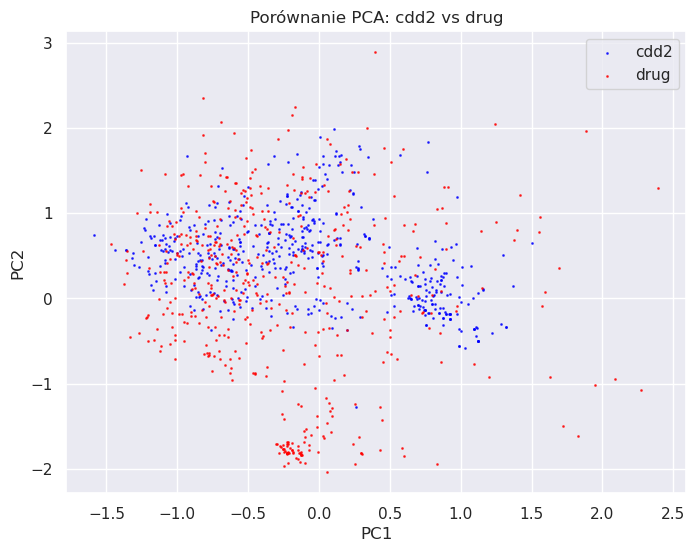

In [17]:
#PCA visualization
X = np.vstack([fpcdd2, fp_drug])
labels = ['cdd2'] * len(fpcdd2) + ['drug'] * len(fp_drug)
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X)
pca_cdd2 = pca_result[:len(fpcdd2)]
pca_drug = pca_result[len(fp_drug):]
plt.figure(figsize=(8, 6))
plt.scatter(pca_cdd2[:, 0], pca_cdd2[:, 1], label='cdd2', alpha=0.7, color='blue',s=1)
plt.scatter(pca_drug[:, 0], pca_drug[:, 1], label='drug', alpha=0.7, color='red',s=1)

plt.title("Porównanie PCA: cdd2 vs drug")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()
plt.grid(True)
plt.show()

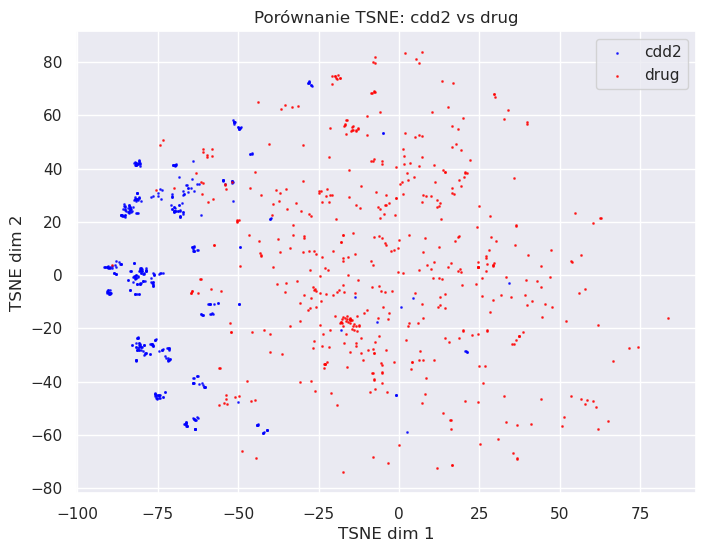

In [18]:
tsne = TSNE(perplexity=30)
X_embedded = tsne.fit_transform(X)
tsne_cdd2 = X_embedded[:len(fpcdd2)]
tsne_drug = X_embedded[len(fp_drug):]
plt.figure(figsize=(8, 6))
plt.scatter(tsne_cdd2[:, 0], tsne_cdd2[:, 1], label='cdd2', alpha=0.7, color='blue',s=1)
plt.scatter(tsne_drug[:, 0], tsne_drug[:, 1], label='drug', alpha=0.7, color='red',s=1)

plt.title("Porównanie TSNE: cdd2 vs drug")
plt.xlabel("TSNE dim 1")
plt.ylabel("TSNE dim 2")
plt.legend()
plt.grid(True)
plt.show()

# Activity models
We build a random forest model to classify between decoys and actives. The classification metrics are very good, this indicates most likely that the decoys are too diverse and to odifferent making the classification tasks artificially easy. Also, the imbalance of the data (more decoys than actives) inflates the AUC due to early enrichment.

In [19]:
# load our data
decoys = [mol for mol in Chem.SmilesMolSupplier("AR_decoys.ism") if mol]

# prepare our data for machine learning inputs
all_molecules = cdd2 + decoys
y = [1]*len(cdd2) + [0]*len(decoys) # activity labels 1 for active 0 for decoy
X = [np.array(AllChem.GetMorganFingerprintAsBitVect(m,radius=2,nBits=1024)) for m in all_molecules]

Mathew correlation coefficient is: 0.6477710926995685


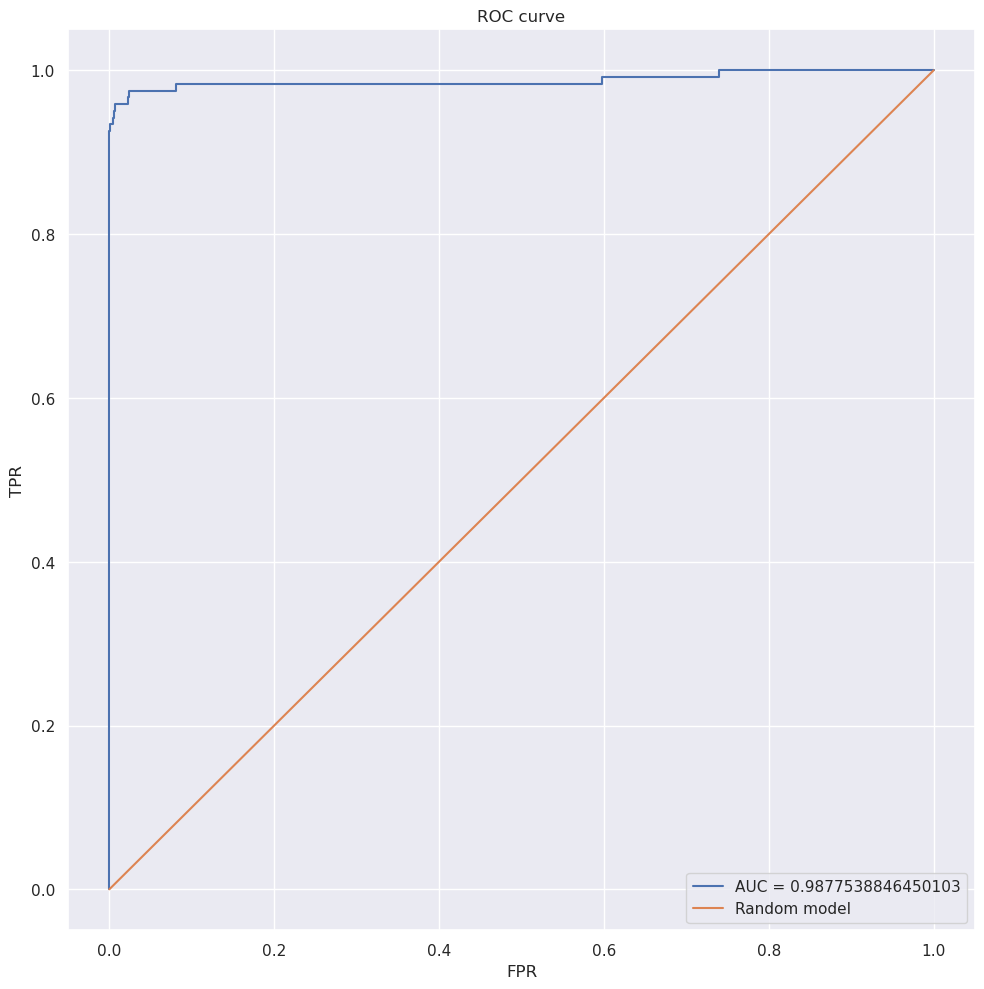

In [20]:
# split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# build the model
RFC = RandomForestClassifier(n_jobs=-1,n_estimators=100,max_depth=5)
RFC.fit(X_train,y_train)
# try on test data
y_pred = RFC.predict(X_test)
# show ROC curve and print AUC and MCC
print("Mathew correlation coefficient is:",matthews_corrcoef(y_pred,y_test))
probs = [x[1] for x in RFC.predict_proba(X_test)]
fpr,tpr,_ = roc_curve(y_test,probs)
plt.plot(fpr,tpr,label=f"AUC = {roc_auc_score(y_test,probs)}")
plt.plot([0,1],[0,1],label="Random model")
plt.title("ROC curve")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()